# Acceleration.jl Examples Notebook

This notebook contains three numerical experiments:

1. Least squares;
2. Federeated learning with gradient compression; and 
3. Accelerated SAGA for finite-sum problems. 


We start by activating the (local) Acceleration sofware package and loading it. Also, we load the package 'Plots' to generate the figures.

In [1]:
] activate ../../Acceleration

  Activating project at `~/Desktop/Acceleration`


In [2]:
using Acceleration
using Plots

┌ Info: Precompiling Acceleration [68ffc869-97d4-4f7f-9157-458f742a44b9]
└ @ Base loading.jl:1423
┌ Warning: Package Acceleration does not have Clp in its dependencies:
│ - If you have Acceleration checked out for development and have
│   added Clp as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Acceleration
└ Loading Clp into Acceleration from project dependency, future warnings for Acceleration are suppressed.


Finally, we load a library that has multiple oracle functions, i.e., how we will compute gradients (exact, stochastic, gradient compression, SAGA, etc. )

In [10]:
include("../src/oracles.jl");

## Least Squares

The following lines load data and ML model. The function ```linear_regression``` takes as input a ```data``` matrix and a vector of ```labels``` and returns the necessary functions and constants to run a first-order algorithm. The objective function ```f```, the first-order ```oracle```, the projection function ```∇ϕ_cjg```, and the constant ```σ``` are as defined in the paper. 

In [11]:
n = 50;
A = rand(n,n);
b = rand(n);
f,oracle,∇ϕ_cjg,σ,L,μ  = linear_regression(A,b);

The next block of lines run multiple first-order algorithms. We need to set the starting point ```x_0``` and the number of iterations ```k``` the algorithm will run. The "optimal" value is obtained by running the algorithm for ```5k``` iterations with an exact oracle. 

**Tunable parameters:** The reviewers can change the ```oracle_fun``` and the value of parameter ```lambda```. See the instructions in the code. 

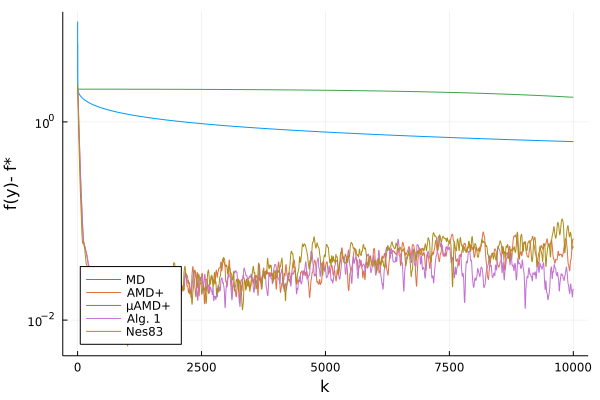

In [12]:
x_0 = zeros(n);
k = 10000;
λ = 1; # Set λ ∈ (0,1] and observe how this parameter affects convergence of Algorithm 1

f_star = AMD_plus(f,oracle,∇ϕ_cjg,x_0,σ,L,5*k).optval;

oracle_fun = oracle;
oracle_fun = stochastic_oracle; 
# Uncomment the line above to use a stochastic oracle (zero mean and unit variance)

p1 = MD(f,oracle_fun,∇ϕ_cjg,x_0,σ,L,k).fs .-f_star;
p2 = AMD_plus(f,oracle_fun,∇ϕ_cjg,x_0,σ,L,k).fs .-f_star;
p3 = μAMD_plus(f,oracle_fun,∇ϕ_cjg,x_0,L,μ,k).fs .-f_star;
p4 = AGM(f,oracle_fun,∇ϕ_cjg,x_0,σ,L,μ,k,λ,Inf).fs .-f_star;
p5 = Nesterov83(f,oracle_fun,x_0,k) .- f_star

gap = max.(1e-12,hcat(p1,p2,p3,p4,p5));
plot(gap, yaxis=:log, xlabel="k", ylabel="f(y)- f*", label = ["MD" "AMD+" "μAMD+" "Alg. 1" "Nes83"],legend=:bottomleft)

## Federated Optimization

The following block of lines load the LIBSVM data (mushroom dataset) and the functions necessary for the FOMs. The objective function ```f```, the first-order ```oracle```, the projection function ```∇ϕ_cjg```, and the constant ```σ``` are as defined in the paper. 

In [13]:
data,labels,m,n = load_libsvm_dataset("mushrooms",1000); 
f,oracle,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

┌ Info: Loading dataset mushrooms with 1000 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Acceleration/src/libsvm_datasets.jl:25


The next block of lines run multiple first-order algorithms. We need to set the starting point ```x_0``` and the number of iterations ```k``` the algorithm will run. The "optimal" value is obtained by running the algorithm for ```5k``` iterations with an exact oracle. 

**Tunable parameters:** The reviewers can change the ```oracle_fun``` to test different gradient compression schemes. See the instructions in the code. The figure shows performance against the number of iterations for simplicity. 

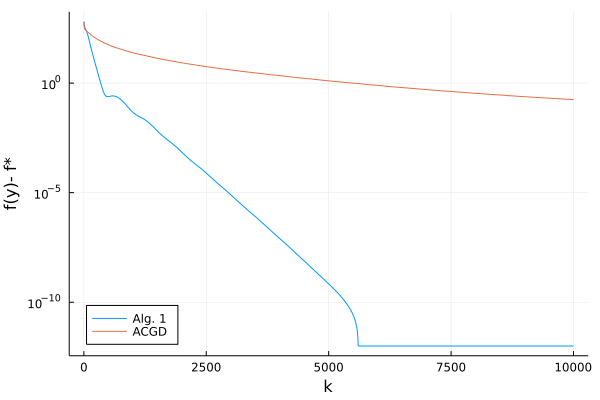

In [14]:
x_0 = zeros(n);
k = 10000; μ = 1;

f_star = AMD_plus(f,oracle,∇ϕ_cjg,x_0,σ,L,5*k).optval;
λ = 0.1;
ω = (1-λ)/(1+λ);

oracle_fun = random_sparsification;
# Uncomment the lines below to use another type of oracle
#oracle_fun = oracle; # i.e., exact gradients
#oracle_fun = dithering;
#oracle_fun = natural_compression;

p1 = AGM(f,oracle_fun,∇ϕ_cjg,x_0,σ,L,μ,k,λ,Inf).fs .-f_star;
p2 = μACGD(f,oracle_fun,x_0,L,μ,k,ω) .-f_star;

gap = max.(1e-12,hcat(p1,p2));
plot(gap, yaxis=:log, xlabel="k", ylabel="f(y)- f*", label = ["Alg. 1" "ACGD" ], legend=:bottomleft)

## Accelerated SAGA

The following block of lines load the LIBSVM data (mushroom dataset) and the functions necessary for the FOMs. The objective function ```f```, the first-order ```oracle```, the projection function ```∇ϕ_cjg```, and the constant ```σ``` are as defined in the paper. 

In [15]:
data,labels,m,n = load_libsvm_dataset("mushrooms",1000); 
f,oracle,∇ϕ_cjg,σ,L,μ = logistic_regression(data,labels,1);

┌ Info: Loading dataset mushrooms with 1000 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Acceleration/src/libsvm_datasets.jl:25


The next block of lines run Algorithm 1 with different oracles: SAGA, exact gradient, and mini-batch. We have included in the simulation Algorithm 1 with p=5 and mini-batch. 

**Tunable parameters:** The reviewers can change the size of the mini-batch. The mini-batch size also affects the number of data samples used in SAGA. 

  1.176797 seconds (8.62 M allocations: 2.716 GiB, 22.00% gc time, 1.69% compilation time)


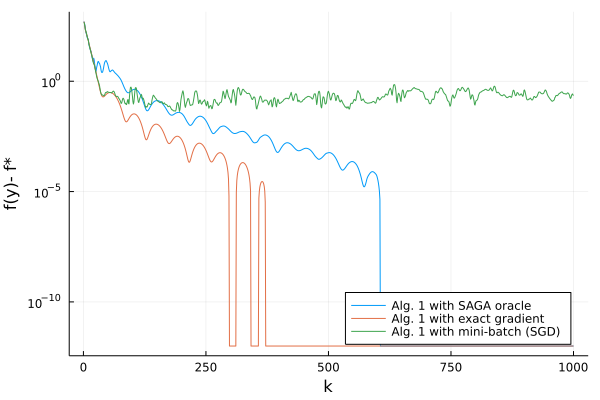

In [16]:
x_0 = zeros(n);
mini_batch = 100; # Change the mini-batch size and observe how this affects performance
include("../src/saga.jl") # Load SAGA algorithms

x_0 = zeros(n);
k = 1000;

f_star = AMD_plus(f,full_gradient,∇ϕ_cjg,x_0,σ,L,2*k).optval;

μ = 0.01; L = 1000; # Squeeze the condition number for shorter sim. 

p1 = zeros(k)
p2 = zeros(k)
p3 = zeros(k)

runs = 1
for j=1:runs

    @time p1 = (1-1/j).*p1 .+ (1/j).*max.(1e-12,AGM(f,∇fvr,∇ϕ_cjg,x_0,σ,L,μ,k,1,Inf).fs .- f_star);
    p2 = (1-1/j).*p2 .+ (1/j).*max.(1e-12,AGM(f,full_gradient,∇ϕ_cjg,x_0,σ,L,μ,k,1,Inf).fs .- f_star);
    p3 = (1-1/j).*p3 .+ (1/j).*max.(1e-12,AGM(f,mini_batch_gradient,∇ϕ_cjg,x_0,σ,L,μ,k,1,Inf).fs .- f_star);
end

gap = max.(1e-12,hcat(p1,p2,p3));
plot(gap, yaxis=:log, xlabel="k", ylabel="f(y)- f*",label = ["Alg. 1 with SAGA oracle" "Alg. 1 with exact gradient" "Alg. 1 with mini-batch (SGD)"], legend=:bottomright)